# Suplementary Material - III - Satellite Exploration

In [1]:
# !pip install --upgrade scikit-image
# !pip install pyproj
# !pip install tqdm
# !pip install -U scipy==1.0.0

### Imports & Definitions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

import os, sys

from itertools import product
import pyproj
import matplotlib.image as mpimg
from tqdm import tqdm
from skimage import transform


from dataLoaderSatExploration import DataLoaderSat, preprocess_time


from tf.keras.models import Model, load_model
from tf.keras.layers import Input
from tf.keras.losses import mean_squared_error



batchSize = 1
pathToModel = "../IV.B_ablation_study/denseNet/gr_oh_loc_time_TA/weights.30-0.57407.hdf5"
gpuNumber = 4

transLabels = ["dirty", "daylight", "night", "sunrisesunset", "dawndusk", "sunny", "clouds", 
               "fog", "storm", "snow", "warm", "cold", "busy", "beautiful", "flowers", "spring", 
               "summer", "autumn", "winter", "glowing", "colorful", "dull", "rugged", "midday", 
               "dark", "bright", "dry", "moist", "windy", "rain", "ice", "cluttered", "soothing", 
               "stressful", "exciting", "sentimental", "mysterious", "boring", "gloomy", "lush"]

## GPU selection
import tensorflow as tf 
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[gpuNumber], 'GPU')
tf.config.experimental.set_memory_growth(gpus[gpuNumber], True)



#######################
##    Custom MSE     ##
#######################
# We will compute the MSE only for the consistent inputs
def transient_mse(y_true, y_pred):
    return tf.sum(mean_squared_error(y_true[0::2,:], y_pred[0::2,:]), axis=-1)



#######################
## Deprocess time
#######################
def deprocess_time(time):
    month, hour = time
    month = (11.0 / 2.0) * (month + 1) + 1
    hour = (23.0 / 2.0) * (hour + 1)
    return (int(round(month)), int(round(hour)))

def deprocess_loc(loc):
    _earth_radius = 6378137.0
    x,y,z = loc
    ecef = pyproj.Proj(proj='geocent', ellps='WGS84', datum='WGS84')
    lla = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')
    
    lon, lat, alt = pyproj.transform(ecef, lla, x * _earth_radius, y*_earth_radius, z*_earth_radius, radians=False)
    return (lat, lon, alt)

### Load architecture and get pointers to specific layers
As we will process the features from multiple timestamps, we avoid re-processing the features for the ground-level image, location, and satellite image

In [2]:
baseModel = load_model(pathToModel, custom_objects={"transient_mse": transient_mse})
print(baseModel.summary())

groundBranchModel = Model(baseModel.get_layer("groundInput").input, 
                          baseModel.get_layer("batch_normalization_2").output)
aerialBranchModel = Model(baseModel.get_layer("aerialInput").input, 
                          baseModel.get_layer("batch_normalization_4").output)
locBranchModel = Model(baseModel.get_layer("locationInput").input, 
                       baseModel.get_layer("batch_normalization_7").output)
timeBranchModel =  Model(baseModel.get_layer("timeInput").input, 
                         baseModel.get_layer("batch_normalization_10").output)

combinedFeaturesInput = Input(shape=(512,), name='concatenate_1_proxy')
consistFeatures = baseModel.get_layer("consist_fc1")(combinedFeaturesInput)
consistFeatures = baseModel.get_layer("batch_normalization_11")(consistFeatures)
consistFeatures = baseModel.get_layer("consist_fc2")(consistFeatures)
consistFeatures = baseModel.get_layer("batch_normalization_12")(consistFeatures)
consistFeatures = baseModel.get_layer("consist_fc3")(consistFeatures)
consistModel = Model(combinedFeaturesInput, consistFeatures)


grFeaturesInput = Input(shape=(128,), name='grFeaturesProxy')
grTransFeatures = baseModel.get_layer("gr_trans_fc1")(grFeaturesInput)
grTransFeatures = baseModel.get_layer("batch_normalization_13")(grTransFeatures)
grTransFeatures = baseModel.get_layer("gr_trans_fc2")(grTransFeatures)
grTransFeatures = baseModel.get_layer("batch_normalization_14")(grTransFeatures)
grTransPred = baseModel.get_layer("gr_trans_fc3")(grTransFeatures)
grTransModel = Model(grFeaturesInput, grTransPred)

combinedFeaturesInput = Input(shape=(384,), name='aeLocTimeFeaturesProxy')
combinedTransFeatures = baseModel.get_layer("ae_loc_time_trans_fc1")(combinedFeaturesInput)
combinedTransFeatures = baseModel.get_layer("batch_normalization_15")(combinedTransFeatures)
combinedTransFeatures = baseModel.get_layer("ae_loc_time_trans_fc2")(combinedTransFeatures)
combinedTransFeatures = baseModel.get_layer("batch_normalization_16")(combinedTransFeatures)
combinedTransPred = baseModel.get_layer("ae_loc_time_trans_fc3")(combinedTransFeatures)
combinedTransModel = Model(combinedFeaturesInput, combinedTransPred)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
groundInput (InputLayer)        (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
aerialInput (InputLayer)        (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
locationInput (InputLayer)      (None, 3)            0                                            
__________________________________________________________________________________________________
timeInput (InputLayer)          (None, 2)            0                                            
________

--------------
--------------
--------------
--------------


### Generate the timestamp consistency heatmap and the transient attributes for an image

The `initialSkip` and `skipCount` variables allow us to control which image would be selected (without needing to adapt much of the dataLoader)

In [4]:
dl = DataLoader("test", 
                includeLocation = True, 
                includeSatellite = True, 
                outputTransientAttributes = True)

adjustedHeatMapMatrix = np.zeros((12, 24))

initialSkip = skipCount = 10

for batch, _ in dl.loadTestDataInBatches(batchSize):
    if skipCount >= 1:
        skipCount-=1
        continue


    grImg, aeImg, locInfo, timeInfo = [batch[i][0:1] for i in range(len(batch))]
    
    dLoc = deprocess_loc(locInfo[0])
    dTime = deprocess_time(timeInfo[0])

    grFeatures = groundBranchModel.predict_on_batch(grImg)
    aeFeatures = aerialBranchModel.predict_on_batch(aeImg)
    locFeatures = locBranchModel.predict_on_batch(locInfo)
    timeFeatures = timeBranchModel.predict_on_batch(timeInfo)

    aeLocTimeFV = np.hstack((aeFeatures, locFeatures, timeFeatures))
    targetTransPred = combinedTransModel.predict_on_batch(aeLocTimeFV)[0]
    

    timeList, predList = [], []
    for month, hour in product(range(1,13), range(24)):
        tFeatures = timeBranchModel.predict_on_batch(preprocess_time((month, hour)).reshape(1,-1))
        
        concatFV = np.hstack((grFeatures, aeFeatures, locFeatures, tFeatures))
        pred = consistModel.predict_on_batch(concatFV)
        consistentProb = pred[0][0]
        
        timeList += [(month, hour)]
        predList += [consistentProb]

    sortedTimeList = [(y,x) for y,x in sorted(zip(predList,timeList), 
                                                  key=lambda pair: pair[0], reverse=True)]
    sortedProbs = [l[0] for l in sortedTimeList]
    sortedTimes = [l[1] for l in sortedTimeList]

    
    deltaHtoGT = 12 - dTime[1] 
    deltaMtoGT = 6 - dTime[0]

    for i in range(len(sortedTimes)):
        month, hour = sortedTimes[i]
        adjustedHeatMapMatrix[(month + deltaMtoGT)%12,((hour + deltaHtoGT)%24)] += sortedProbs[i]
        
    break



Create a folder to save the images:

In [7]:
skipPath = os.path.join("./satAnalysis/", str(initialSkip))
os.makedirs(skipPath)

Plot the sample, its consistency heatmap and distribution of transient attributes:

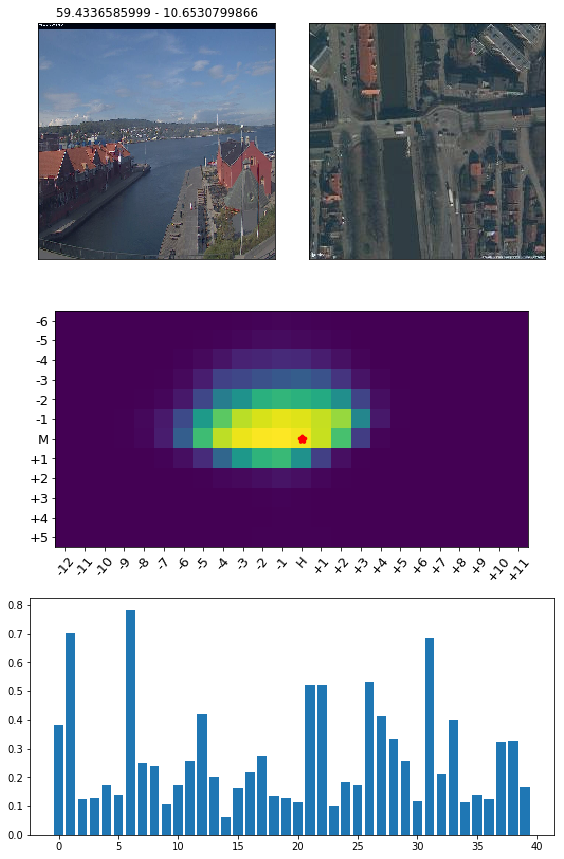

In [8]:
fig=plt.figure(figsize=(8,12))
columns = 2
rows = 3

fig.add_subplot(rows, columns, 1)
fig.tight_layout()

plt.xticks([])
plt.yticks([])
plt.imshow((grImg[0] - np.min(grImg[0])) / (np.max(grImg[0]) - np.min(grImg[0])) )
plt.title(str(dLoc[0]) + " - " + str(dLoc[1]))

fig.add_subplot(rows, columns, 2)
fig.tight_layout()
plt.xticks([])
plt.yticks([])
plt.imshow((aeImg[0] - np.min(aeImg[0])) / (np.max(aeImg[0]) - np.min(aeImg[0])) )

fig.add_subplot(3, 1, 2)
fig.tight_layout()

plt.xticks(range(0,24), 
           ["-12", "-11", "-10", "-9", "-8", "-7", "-6", "-5", "-4", "-3", "-2", "-1", "H",
           "+1", "+2", "+3", "+4", "+5", "+6", "+7", "+8", "+9", "+10", "+11"], 
           rotation=50, size=13)
plt.yticks(range(0,13), 
           ["-6", "-5", "-4", "-3", "-2", "-1", "M", "+1", "+2", "+3", "+4", "+5"],
           size=13)
plt.scatter(12, 6, lw=4, c='r', marker="*")
plt.imshow(adjustedHeatMapMatrix, cmap='viridis')


fig.add_subplot(3, 1, 3)
fig.tight_layout()

plt.bar(range(40), targetTransPred)

plt.savefig(os.path.join(skipPath, "base.png"))
plt.show()

### Estimating the transient attributes for other satellite images in the dataset

In [9]:
idx=0
pbar = tqdm(total=len(list(set(dl.aerialPaths))))

listOfTransAttributes = []
setOfImgs = []

for aeImg, locBatch in dl.loadSatImagesInBatches(batchSize):
    idx += 1
    pbar.update(1)
    
    
    #### Ignore satellite images that were already seen
    alreadySeen = False
    for img in setOfImgs:
        if np.max(aeImg - img) == 0:
            alreadySeen = True
            break
    if alreadySeen:
        continue
    else:
        setOfImgs+=[aeImg]
    
    
    
    ## Process the new satellite image
    aeFeatures = aerialBranchModel.predict_on_batch(aeImg)

    ## Combine it with the location and timestamp features from the original sample
    aeLocTimeFV = np.hstack((aeFeatures, locFeatures, timeFeatures))
    
    ## Extract transient and add it to the list
    transPred = combinedTransModel.predict_on_batch(aeLocTimeFV)[0]
    listOfTransAttributes += [(transPred, aeImg, locBatch)]

pbar.close()

100%|██████████| 20053/20053 [30:30:01<00:00,  5.48s/it]   


## Comparing and sorting Transient Attributes (L2 norm)

In [16]:
# Compute the L2 Norm between TAs
taDists = [np.linalg.norm(targetTransPred - ta[0]) for ta in listOfTransAttributes]

# When it is the same sat image, the TAs are equal
taDists = [x if x!=0.0 else 10000 for x in taDists]

# Sort
sortedList = [y for y,x in sorted(zip(listOfTransAttributes,taDists), 
                                                  key=lambda pair: pair[1], reverse=False)]

Looking at the 20 satellite images with the most **similiar** transient attributes:

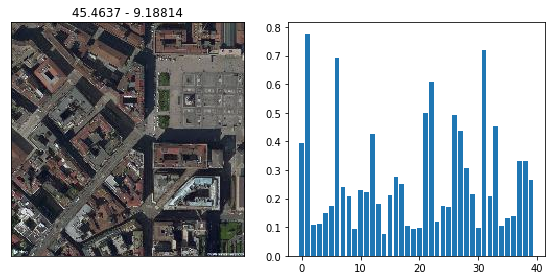

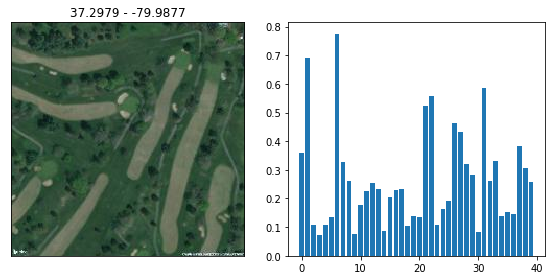

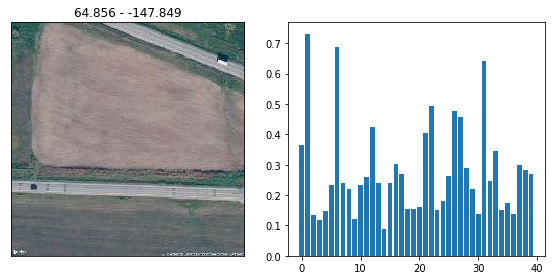

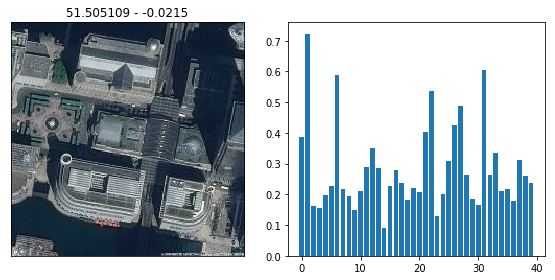

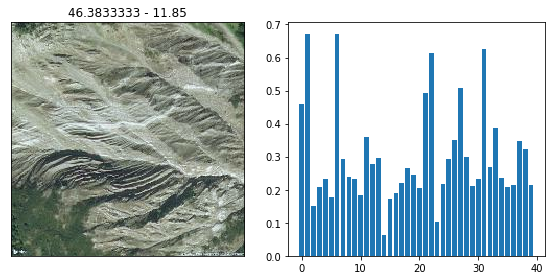

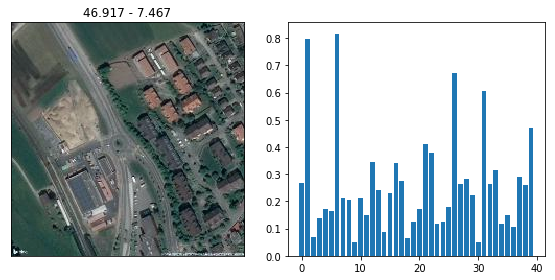

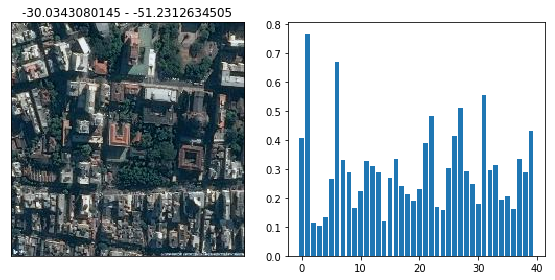

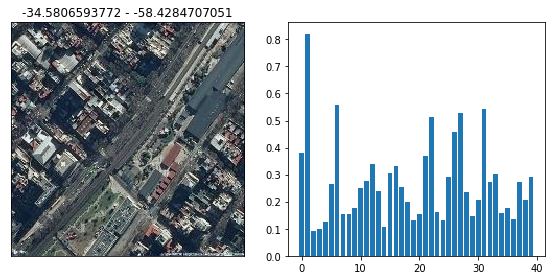

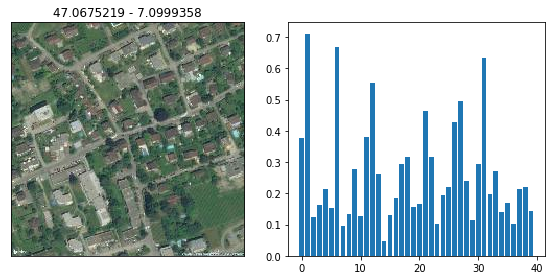

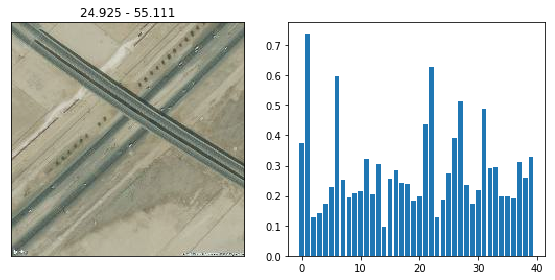

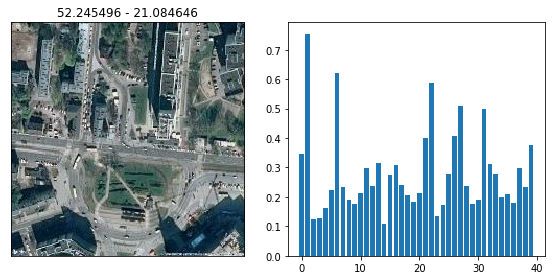

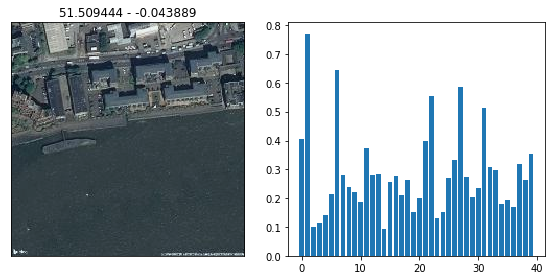

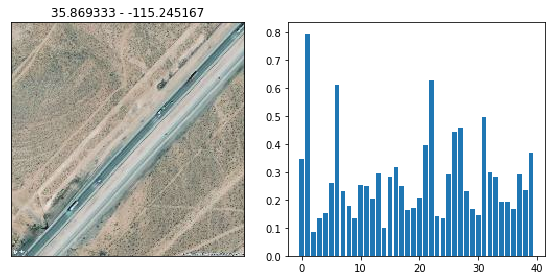

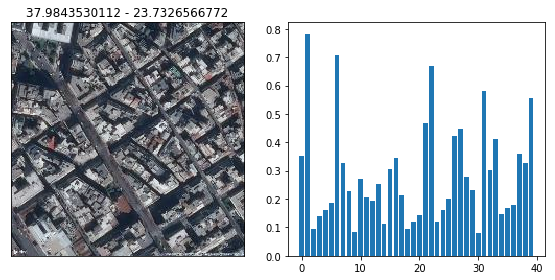

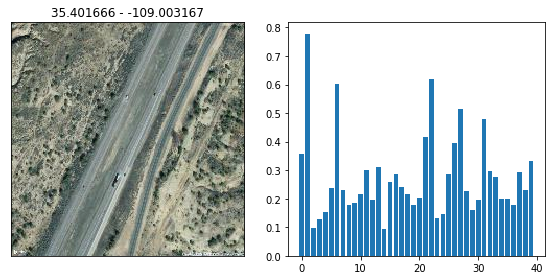

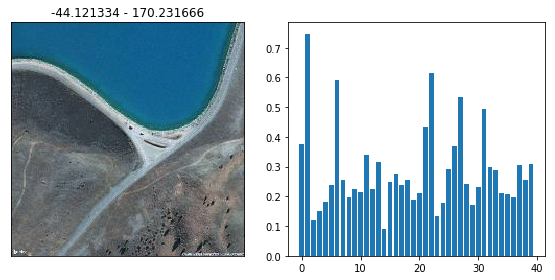

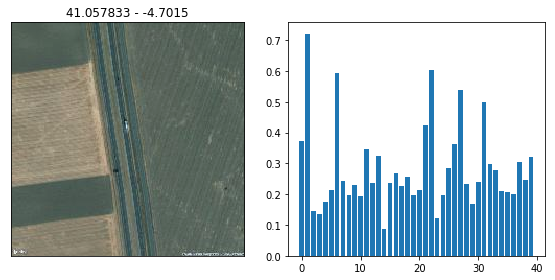

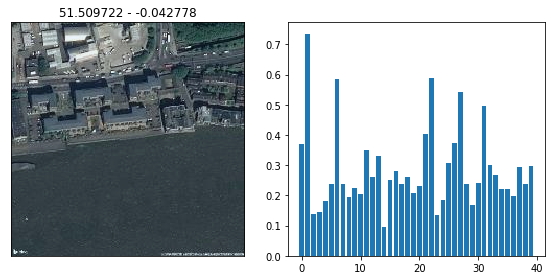

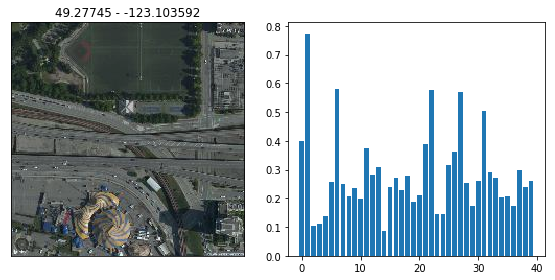

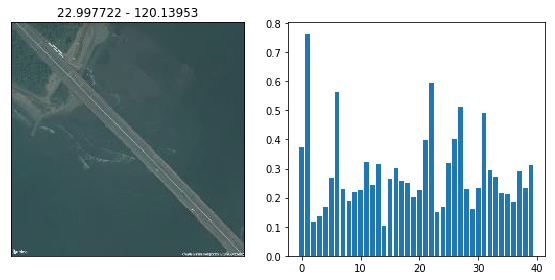

In [17]:
tmpIdx = 1
for ta, aeImg, loc in sortedList[:20]: # considering only the first 20
    
    fig=plt.figure(figsize=(8,4))
    columns = 2
    rows = 1

    fig.add_subplot(rows, columns, 1)
    fig.tight_layout()
    plt.xticks([])
    plt.yticks([])
    plt.imshow((aeImg[0] - np.min(aeImg[0])) / (np.max(aeImg[0]) - np.min(aeImg[0])) )
    plt.title(str(loc[0][0]) + " - " + str(loc[0][1]))


    fig.add_subplot(rows, columns, 2)
    fig.tight_layout()
    plt.bar(range(40), ta)

    plt.savefig(os.path.join(skipPath, "transAtt_L2_" + str(tmpIdx).zfill(2) + ".png"))
    plt.show()
    tmpIdx += 1
    

Looking at the 20 satellite images with the most **disimiliar** transient attributes:

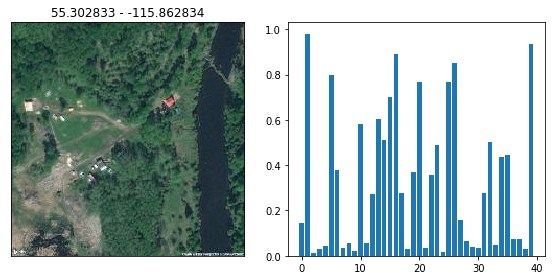

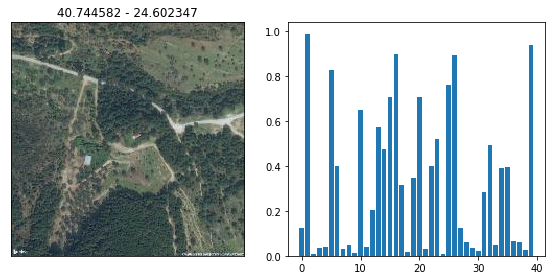

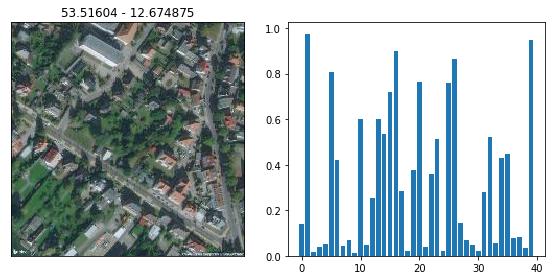

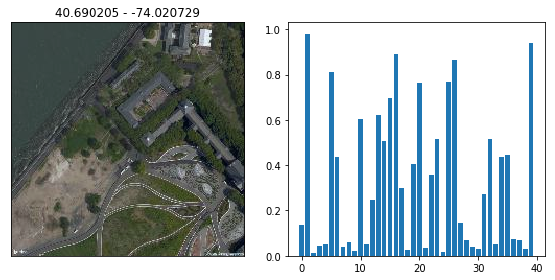

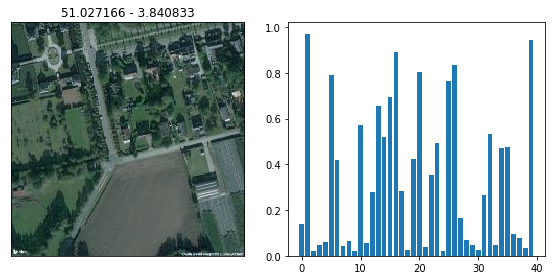

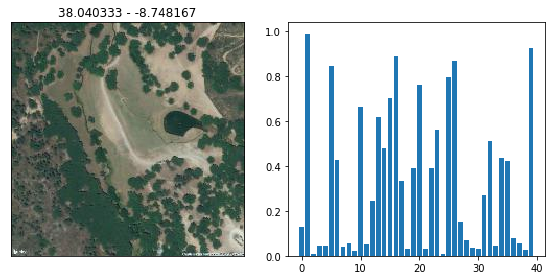

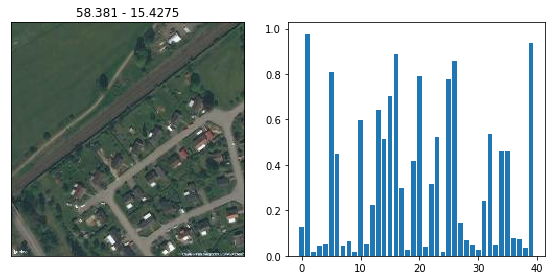

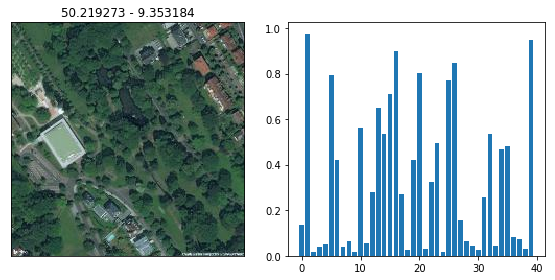

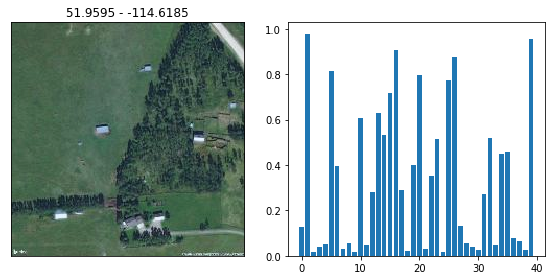

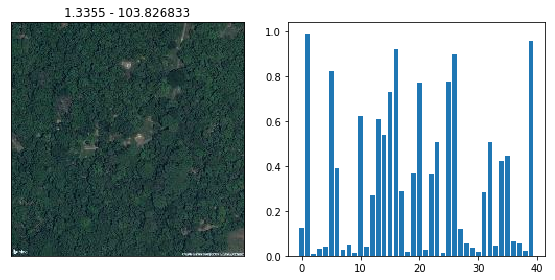

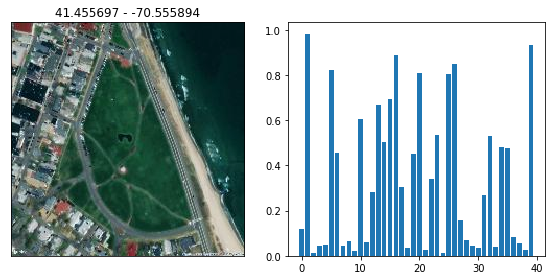

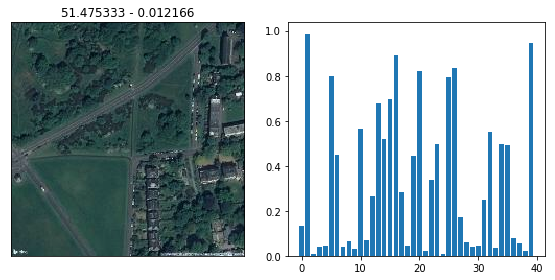

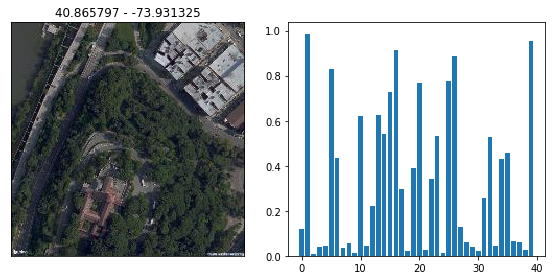

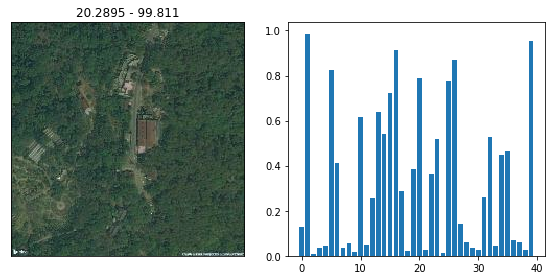

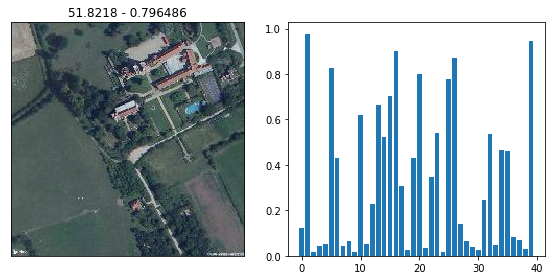

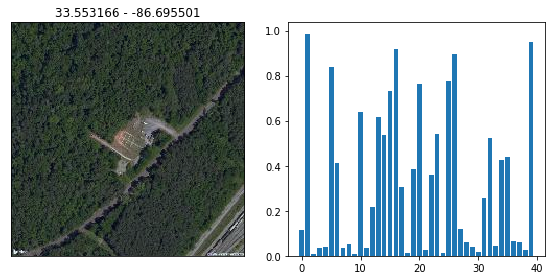

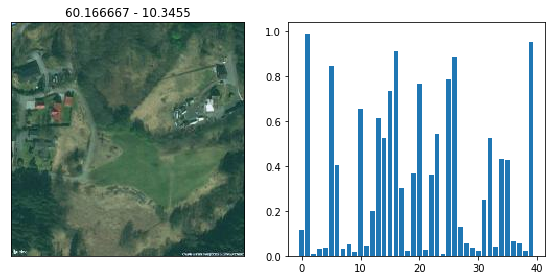

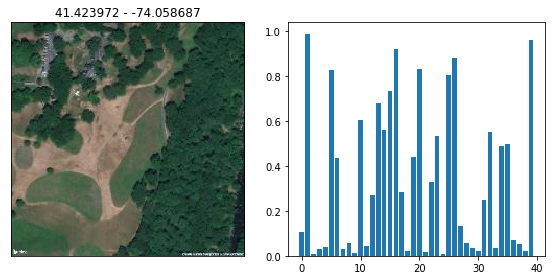

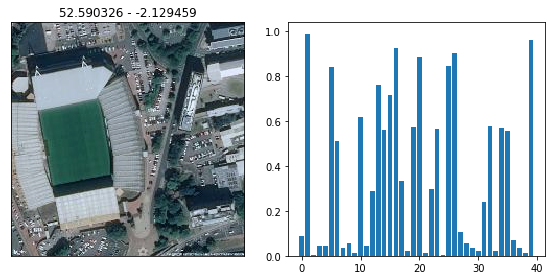

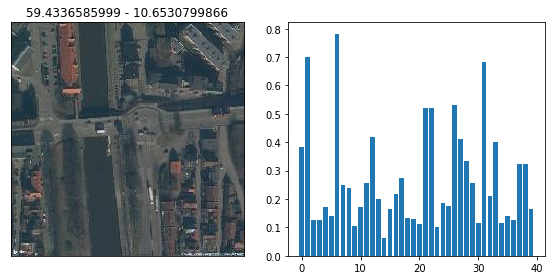

In [18]:
tmpIdx = -20
for ta, aeImg, loc in sortedList[-20:]:
    
    fig=plt.figure(figsize=(8,4))
    columns = 2
    rows = 1

    fig.add_subplot(rows, columns, 1)
    fig.tight_layout()
    plt.xticks([])
    plt.yticks([])
    plt.imshow((aeImg[0] - np.min(aeImg[0])) / (np.max(aeImg[0]) - np.min(aeImg[0])) )
    plt.title(str(loc[0][0]) + " - " + str(loc[0][1]))


    fig.add_subplot(rows, columns, 2)
    fig.tight_layout()
    plt.bar(range(40), ta)

    plt.savefig(os.path.join(skipPath, "transAtt_L2_" + str(tmpIdx).zfill(2) + ".png"))
    plt.show()
    tmpIdx += 1
    